In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/github/HackerEarth---How-NOT-to-lose-a-customer-in-10-days/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/github/HackerEarth---How-NOT-to-lose-a-customer-in-10-days


In [8]:
import pandas as pd
import lightgbm as lgb
import plotly.express as px
import numpy as np


import warnings
warnings.filterwarnings("ignore")


# Modelling packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

# Feature Engineering

In [ ]:
train_data = pd.read_csv("dataset/train.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [ ]:
train_data.head(2)

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1


## Data Cleaning and Pre-processing

### churn_risk_score

In [ ]:
print(train_data.shape[0], train_data.customer_id.nunique())
# customer id can be the unique identifier

36992 36992


In [ ]:
# Analysing target variable
train_data.churn_risk_score.value_counts() # there is a class imbalance found will be treated afterwards

 3    10424
 4    10185
 5     9827
 2     2741
 1     2652
-1     1163
Name: churn_risk_score, dtype: int64

In [ ]:
# -1 should not be there so dropping all the rows with -1
train_data = train_data[train_data.churn_risk_score != -1]

### Name

In [ ]:
# Name col does not add any value
del train_data['Name']

### security_no

In [ ]:
print(train_data.security_no.nunique()) # as security no is redundant we can drop it
del train_data['security_no']

35829


### gender

In [ ]:
train_data.gender.value_counts() 

F          17892
M          17881
Unknown       56
Name: gender, dtype: int64

In [ ]:
# dropping unkown gender
train_data = train_data[train_data.gender != 'Unknown']

# OHE gender column
train_data = ohe(train_data, ['gender'])

### age

In [ ]:
# Checking outliers in age
fig = px.box(train_data, y="age")
fig.show()

In [ ]:
# age is fine, forming normal distribution

### region_category

In [ ]:
# Checking columns with nulls
list(train_data.columns[train_data.isna().any()])

['region_category', 'preferred_offer_types', 'points_in_wallet']

In [ ]:
# Region column
train_data[train_data.region_category.isna()].shape[0] # Need to drop these many rows, but if the columns turns out to be non contributing can go back to accept these rows

5256

In [ ]:
train_data.region_category = train_data.region_category.replace(np.nan, 'new_region')

In [ ]:
train_data.region_category.value_counts()

Town          13675
City          12299
new_region     5256
Village        4543
Name: region_category, dtype: int64

In [ ]:
# OHE region data
train_data = ohe(train_data, ['region_category'])

### membership_category

In [ ]:
train_data.membership_category.unique()

array(['Platinum Membership', 'Premium Membership', 'No Membership',
       'Gold Membership', 'Silver Membership', 'Basic Membership'],
      dtype=object)

In [ ]:
# Label Encoder
train_data.membership_category = train_data.membership_category.map({
                                                                    'No Membership': 0,
                                                                    'Basic Membership': 1,
                                                                    'Silver Membership': 2,
                                                                    'Gold Membership': 3,
                                                                    'Platinum Membership': 4,
                                                                    'Premium Membership': 5,
                                                                    })

In [ ]:
train_data.membership_category.unique() 

array([4, 5, 0, 3, 2, 1])

### joining_date

In [ ]:
train_data.joining_date

0        2017-08-17
1        2017-08-28
2        2016-11-11
3        2016-10-29
4        2017-09-12
            ...    
36987    2017-09-21
36988    2016-06-27
36989    2016-09-11
36990    2017-06-15
36991    2015-10-23
Name: joining_date, Length: 35773, dtype: object

In [ ]:
# using it to calculate loyalty
train_data['joining_date'] = pd.to_datetime(train_data['joining_date'])
train_data['max_date'] = max(train_data['joining_date'])
train_data['customer_loyalty'] = train_data['max_date'] - train_data['joining_date']
train_data['customer_loyalty'] = train_data['customer_loyalty'].dt.days
del train_data['joining_date']
del train_data['max_date']

In [ ]:
train_data.customer_loyalty

0        136
1        125
2        415
3        428
4        110
        ... 
36987    101
36988    552
36989    476
36990    199
36991    800
Name: customer_loyalty, Length: 35773, dtype: int64

### joined_through_referral

In [ ]:
# joined_through_referral
train_data.joined_through_referral.value_counts()

No     15332
Yes    15158
?       5283
Name: joined_through_referral, dtype: int64

In [ ]:
# ? can be considered as a third category 
# ohe
train_data = ohe(train_data, ['joined_through_referral'])

### referral_id

In [ ]:
train_data.referral_id.value_counts()

xxxxxxxx    17269
CID3979        10
CID43705       10
CID49601       10
CID15792        9
            ...  
CID39151        1
CID2560         1
CID11323        1
CID2288         1
CID38459        1
Name: referral_id, Length: 11110, dtype: int64

In [ ]:
train_data[train_data.referral_id == "CID3979"]['churn_risk_score']

2620     3
4850     2
4892     4
14121    3
16332    3
17823    5
18590    5
24143    4
25061    1
32236    3
Name: churn_risk_score, dtype: int64

In [ ]:
# can be dropped as the most frequent id does not show any significant pattern
del train_data['referral_id']

### preferred_offer_types

In [ ]:
# Checking columns with nulls
list(train_data.columns[train_data.isna().any()])

['preferred_offer_types', 'points_in_wallet']

In [ ]:
train_data[train_data.preferred_offer_types.isna()].shape[0]

275

In [ ]:
# we can drop these many rows
train_data = train_data[train_data.preferred_offer_types.notna()]

In [ ]:
train_data.preferred_offer_types.value_counts()  # ohe

Gift Vouchers/Coupons       11953
Credit/Debit Card Offers    11842
Without Offers              11703
Name: preferred_offer_types, dtype: int64

In [ ]:
# OHE preferred_offer_types
train_data = ohe(train_data, ['preferred_offer_types'])

### medium_of_operation

In [ ]:
train_data.medium_of_operation.value_counts()  

In [ ]:
# OHE
train_data = ohe(train_data, ['medium_of_operation'])

### internet_option

In [ ]:
train_data.columns

In [ ]:
train_data.internet_option.value_counts()

In [ ]:
train_data.internet_option = train_data.internet_option.map({
                                                              'Mobile_Data': 0,
                                                              'Wi-Fi': 1,
                                                              'Fiber_Optic': 2,
                                                              })

### last_visit_time

In [ ]:
train_data.last_visit_time  # needs to be dropped
del train_data['last_visit_time']

### days_since_last_login

In [ ]:
train_data.days_since_last_login.value_counts()

In [ ]:
# replace -999 with 30
train_data['days_since_last_login']= train_data["days_since_last_login"].replace({-999: 30})

### avg_time_spent

In [ ]:
train_data.avg_time_spent  # treat ouliers

In [ ]:
# Checking outliers in avg_time_spent
fig = px.box(train_data, y="avg_time_spent")
fig.show()

In [ ]:
# replacing outliers with the upper threshold
train_data.avg_time_spent[train_data.avg_time_spent >1500] = 1500

train_data.avg_time_spent[train_data.avg_time_spent <0] = 0

In [ ]:
# Checking outliers in avg_time_spent
fig = px.box(train_data, y="avg_time_spent")
fig.show()

### avg_transaction_value

In [ ]:
train_data.avg_transaction_value # treat outliers

In [ ]:
# Checking outliers in avg_time_spent
fig = px.box(train_data, y="avg_transaction_value")
fig.show()

### avg_frequency_login_days

In [ ]:
train_data.avg_frequency_login_days.value_counts()

In [ ]:
train_data.shape[0]

In [ ]:
train_data.avg_frequency_login_days = train_data.avg_frequency_login_days.replace('Error', np.nan)

In [ ]:
train_data.avg_frequency_login_days.value_counts()  # treat outliers

In [ ]:
#Changing datatype
train_data.avg_frequency_login_days = train_data.avg_frequency_login_days.astype(np.float)

In [ ]:
# Dropping these rows
train_data = train_data[~(train_data.avg_frequency_login_days <= 0)]

In [ ]:
# Checking outliers in avg_frequency_login_days
fig = px.box(train_data, y="avg_frequency_login_days")
fig.show()

In [ ]:
# replacing outliers with the upper threshold
train_data.avg_frequency_login_days[train_data.avg_frequency_login_days >60] = 55

In [ ]:
# Checking outliers in avg_frequency_login_days
fig = px.box(train_data, y="avg_frequency_login_days")
fig.show()

In [ ]:
# Replacing NaN's with average
train_data.avg_frequency_login_days = train_data.avg_frequency_login_days.replace(np.nan, np.nanmean(train_data.avg_frequency_login_days, axis=0))

### points_in_wallet

In [ ]:
# Checking columns with nulls
list(train_data.columns[train_data.isna().any()])

In [ ]:
train_data.points_in_wallet.value_counts() # treat outliers

In [ ]:
train_data[train_data.points_in_wallet.isna()].shape[0] # NA's will be replaced by the mean

In [ ]:
fig = px.box(train_data, y="points_in_wallet")
fig.show()

In [ ]:
# Replacing NaN's with average
train_data.points_in_wallet = train_data.points_in_wallet.replace(np.nan, np.nanmean(train_data.points_in_wallet, axis=0))

In [ ]:
# replacing outliers with the upper threshold
train_data.points_in_wallet[train_data.points_in_wallet >1700] = 1700

# replacing outliers with the lower threshold
train_data.points_in_wallet[train_data.points_in_wallet <-400] = -400

### used_special_discount

In [ ]:
train_data.used_special_discount.value_counts() # LE

Yes    20342
No     16650
Name: used_special_discount, dtype: int64

In [ ]:
train_data = train_data[train_data.used_special_discount.isin(['Yes', 'No'])]
# OHE
train_data = ohe(train_data, ['used_special_discount'])

In [ ]:
train_data.columns

### offer_application_preference

In [ ]:
train_data.offer_application_preference.value_counts()

In [ ]:
# OHE
train_data = ohe(train_data, ['offer_application_preference'])

### past_complaint

In [ ]:
train_data[train_data.past_complaint == 'No']['complaint_status'].unique()
# as we see this column is redundant

In [ ]:
del train_data['past_complaint']

### complaint_status

In [ ]:
train_data.complaint_status.value_counts() #ohe

In [ ]:
# OHE
train_data = ohe(train_data, ['complaint_status'])

### feedback

In [ ]:
train_data.feedback.value_counts() #ohe

In [ ]:
# OHE
train_data = ohe(train_data, ['feedback'])

In [ ]:
1/0

In [ ]:
train_data.s

In [ ]:
train_data.shape

In [ ]:
train_data.head()

In [ ]:
# # Analysing gender
# churn_score = train_data.churn_risk_score.unique()
# churn_score.sort()
# gender_unique = train_data.gender.unique()
# male_count = []
# female_count = []
# for i in churn_score:
#   male_count.append(len(train_data[(train_data.churn_risk_score == i) & (train_data['gender'] == 'M')]))
#   female_count.append(len(train_data[(train_data.churn_risk_score == i) & (train_data['gender'] == 'F')]))

# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Bar(name='male', x=churn_score, y=male_count),
#     go.Bar(name='female', x=churn_score, y=female_count)
# ])
# # Change the bar mode
# fig.update_layout(barmode='group')
# fig.show()

# Functions

In [9]:
def ohe_prep(main_data, col_ohe, prefx):
    bridge_df = main_data[[col_ohe]]
    # generate binary values using get_dummies
    dum_df = pd.get_dummies(bridge_df, columns=[col_ohe], prefix=[prefx] , drop_first=True)
    # merge with main df bridge_df on key values
    del main_data[col_ohe]
    return main_data.join(dum_df)

def ohe(df, col):
  for i in col:
    df = ohe_prep(df,i,i)
  return df

def data_processing_train(train_data):

  # Name col does not add any value
  train_data = train_data[train_data.churn_risk_score != -1]

  return data_processing_test(train_data)

def data_processing_test(train_data):
  
  train_data.avg_frequency_login_days = train_data.avg_frequency_login_days.replace('Error', np.nan)

  #Changing datatype
  train_data.avg_frequency_login_days = train_data.avg_frequency_login_days.astype(np.float)

  # Replacing NaN's with average
  train_data.avg_frequency_login_days = train_data.avg_frequency_login_days.replace(np.nan, np.nanmean(train_data.avg_frequency_login_days, axis=0))

  # Replacing NaN's with average
  train_data.points_in_wallet = train_data.points_in_wallet.replace(np.nan, np.nanmean(train_data.points_in_wallet, axis=0))

  ### Data manipulations
  # Label Encoder
  train_data.membership_category = train_data.membership_category.map({
                                                                      'No Membership': 0,
                                                                      'Basic Membership': 1,
                                                                      'Silver Membership': 2,
                                                                      'Gold Membership': 3,
                                                                      'Platinum Membership': 4,
                                                                      'Premium Membership': 5,
                                                                      })

  train_data.region_category = train_data.region_category.replace(np.nan, 'new_region')

  # using it to calculate loyalty
  train_data['joining_date'] = pd.to_datetime(train_data['joining_date'])
  train_data['max_date'] = max(train_data['joining_date'])
  train_data['customer_loyalty'] = train_data['max_date'] - train_data['joining_date']
  train_data['customer_loyalty'] = train_data['customer_loyalty'].dt.days


  train_data.preferred_offer_types = train_data.preferred_offer_types.replace(np.nan, 'Nulls')

  train_data.internet_option = train_data.internet_option.map({
                                                                'Mobile_Data': 0,
                                                                'Wi-Fi': 1,
                                                                'Fiber_Optic': 2,
                                                                })


  # OHE region data
  train_data = ohe(train_data, ['gender', 'region_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation',
                                'complaint_status', 'feedback', 'used_special_discount', 'offer_application_preference'])


  train_data = train_data.drop(['past_complaint', 'referral_id', 'joining_date', 'max_date', 'Name', 'security_no', 'last_visit_time'], axis=1)
  return train_data


def scores(model, x_train_array, y_train_array, cv):
  scores = cross_val_score(model, x_train_array, y_train_array, cv=cv)
  print(scores.mean())

# Modelling

In [10]:
train_data = pd.read_csv("dataset/train.csv")
train_data = data_processing_train(train_data)
train_data.shape

(35829, 38)

In [11]:
x_train_array = train_data.copy()
del x_train_array['churn_risk_score']
del x_train_array['customer_id']
# x_train_array = x_train_array.values
y_train_array = train_data['churn_risk_score']
y_train_array = y_train_array.values
x_train, x_test, y_train, y_test = train_test_split(x_train_array, y_train_array, test_size=0.20, random_state=32)
model = XGBClassifier() 
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.05%


In [16]:
x_train.shape

(28663, 36)

In [ ]:
x_train_array.columns

Index(['age', 'membership_category', 'internet_option',
       'days_since_last_login', 'avg_time_spent', 'avg_transaction_value',
       'avg_frequency_login_days', 'points_in_wallet', 'customer_loyalty',
       'gender_M', 'gender_Unknown', 'region_category_Town',
       'region_category_Village', 'region_category_new_region',
       'joined_through_referral_No', 'joined_through_referral_Yes',
       'preferred_offer_types_Gift Vouchers/Coupons',
       'preferred_offer_types_Nulls', 'preferred_offer_types_Without Offers',
       'medium_of_operation_Both', 'medium_of_operation_Desktop',
       'medium_of_operation_Smartphone', 'complaint_status_Not Applicable',
       'complaint_status_Solved', 'complaint_status_Solved in Follow-up',
       'complaint_status_Unsolved', 'feedback_Poor Customer Service',
       'feedback_Poor Product Quality', 'feedback_Poor Website',
       'feedback_Products always in Stock', 'feedback_Quality Customer Care',
       'feedback_Reasonable Price', 'fee

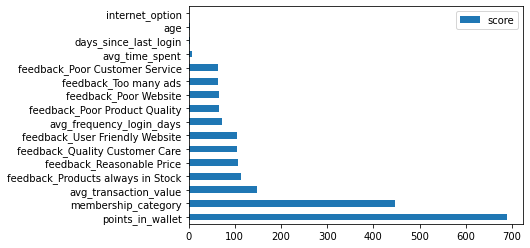

In [ ]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

In [ ]:
['membership_category',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet',
 'feedback_User Friendly Website',
 'feedback_Too many ads',
 'feedback_Poor Website',
 'feedback_Products always in Stock',
 'feedback_Quality Customer Care',
 'feedback_Reasonable Price',
 'feedback_Poor Product Quality',
 'feedback_Poor Customer Service',
 'avg_time_spent']

In [ ]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# # define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=XGBClassifier(), n_features_to_select=10)
model = XGBClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, x_train_array, y_train_array, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

KeyboardInterrupt: ignored

In [ ]:
model = XGBClassifier() 
model.fit(x_train, y_train)

rfe = RFE(model, n_features_to_select=10, verbose =3 )
rfe.fit(x_train, y_train)

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                            colsample_bylevel=1, colsample_bynode=1,
                            colsample_bytree=1, gamma=0, learning_rate=0.1,
                            max_delta_step=0, max_depth=3, min_child_weight=1,
                            missing=None, n_estimators=100, n_jobs=1,
                            nthread=None, objective='multi:softprob',
                            random_state=0, reg_alpha=0, reg_lambda=1,
                            scale_pos_weight=1, seed=None, silent=None,
                            subsample=1, verbosity=1),
    n_features_to_select=10, step=1, verbose=3)

array([ 7,  1,  6,  5,  4,  1,  1,  1,  9, 11, 13, 15, 17, 19, 21, 23, 25,
       27, 26, 24, 22, 20, 18, 16, 14, 12,  3,  2,  1,  1,  1,  1,  1,  1,
        8, 10])

In [ ]:
ranking = pd.DataFrame()

In [ ]:
ranking['names'] = x_train.columns

In [ ]:
ranking['ranks'] = rfe.ranking_

In [ ]:
list(ranking[ranking.ranks <= 10].sort_values('ranks').names)

['membership_category',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet',
 'feedback_User Friendly Website',
 'feedback_Too many ads',
 'feedback_Poor Website',
 'feedback_Products always in Stock',
 'feedback_Quality Customer Care',
 'feedback_Reasonable Price',
 'feedback_Poor Product Quality',
 'feedback_Poor Customer Service',
 'avg_time_spent',
 'days_since_last_login',
 'internet_option',
 'age',
 'used_special_discount_Yes',
 'customer_loyalty',
 'offer_application_preference_Yes']

In [ ]:
# reading dataset

In [63]:
train_data = pd.read_csv("dataset/train.csv")
train_data.shape

(36992, 25)

In [64]:
train_data = data_processing_train(train_data)

In [65]:
x_train_array = train_data.copy()
del x_train_array['churn_risk_score']
del x_train_array['customer_id']
x_train_array = x_train_array.values
y_train_array = train_data['churn_risk_score']
y_train_array = y_train_array.values

In [49]:
(unique, counts) = np.unique(y_blsm, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [50]:
frequencies

array([[    1, 10424],
       [    2, 10424],
       [    3, 10424],
       [    4, 10424],
       [    5, 10424]])

In [28]:
xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=30,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'multi:softmax',
 nthread=-1,
#  scale_pos_weight=1,
 seed=32,)
#  num_class = 11)

x_train, x_test, y_train, y_test = train_test_split(x_train_array, y_train_array, test_size=0.20, random_state=32)

# xgb1.fit(x_train, y_train)
# y_pred = xgb1.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred) 
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [30]:
x_train

array([[39.,  0.,  2., ...,  0.,  0.,  1.],
       [51.,  3.,  1., ...,  0.,  1.,  0.],
       [35.,  5.,  2., ...,  0.,  0.,  1.],
       ...,
       [43.,  0.,  0., ...,  0.,  1.,  0.],
       [43.,  0.,  2., ...,  0.,  0.,  1.],
       [34.,  5.,  1., ...,  0.,  1.,  0.]])

In [ ]:
scores(xgb1, x_train_array, y_train_array, 5)

0.7841134425786341


In [53]:
x_train_array = train_data.copy()
del x_train_array['churn_risk_score']
del x_train_array['customer_id']
x_train_array = x_train_array[['membership_category',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet',
 'feedback_User Friendly Website',
 'feedback_Too many ads',
 'feedback_Poor Website',
 'feedback_Products always in Stock',
 'feedback_Quality Customer Care',
 'feedback_Reasonable Price',
 'feedback_Poor Product Quality',
 'feedback_Poor Customer Service',
 'avg_time_spent']]
x_train_array = x_train_array.values
y_train_array = train_data['churn_risk_score']
y_train_array = y_train_array.values

In [ ]:
xgb1 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'multi:softmax',
#  nthread=-1,
#  scale_pos_weight=1,
 seed=32,)
#  num_class = 11)



In [ ]:
scores(xgb1, x_train_array, y_train_array, 5)

0.7840297177549485


In [12]:
# Accuracy: 54.44%
lgb_base=lgb.LGBMClassifier()
# lgb_base.fit(x_train, y_train)
# y_pred = lgb_base.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred) 
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
bst.get_score(importance_type='gain')

In [ ]:
import lightgbm as lgb
lgb_base=lgb.LGBMClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'multi:softmax',
#  nthread=4,
#  scale_pos_weight=1,
 seed=27,)
#  num_class = 11)

scores = cross_val_score(lgb_base, x_train_array, y_train_array, cv=5)
scores.mean()
# 0.784

0.7826902218528645

In [13]:
pip install catboost

In [14]:
# Catboost

import catboost as cb

# model = cb.CatBoostClassifier(verbose=0)
# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred) 
# print("Accuracy: %.2f%%" % (accuracy * 100.0))


In [15]:
# Random Forest

import sklearn.ensemble as ske

# model = ske.RandomForestClassifier(verbose=0)
# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred) 
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [16]:
from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier(random_state=32)
# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred) 
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
# model = ExtraTreesClassifier(random_state=32)
# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred) 
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [18]:
from sklearn.ensemble import AdaBoostClassifier
# model = AdaBoostClassifier(n_estimators=1000)
# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred) 
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier(random_state=32)
# model.fit(x_train, y_train)
# y_pred = model.predict(x_test)
# accuracy = accuracy_score(y_test, y_pred) 
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [66]:
from sklearn.ensemble import VotingClassifier

gbc = GradientBoostingClassifier(random_state=32)
adbc = AdaBoostClassifier(n_estimators=100)
extrees = ExtraTreesClassifier(random_state=32)
dtc = DecisionTreeClassifier(random_state=32)
rfc = ske.RandomForestClassifier(verbose=0)
# cat = cb.CatBoostClassifier(verbose=0)
lgb_mod = lgb.LGBMClassifier()
xgb_mod = XGBClassifier()

voting_clf = VotingClassifier(
	estimators = [
              #  ('gbc', gbc), ('adbc', adbc), ('extrees',extrees),
              #  ('dtc', dtc), ('rfc', rfc), 
              #  ('cat',cat),
               ('lgb_mod', lgb_mod), 
              #  ('xgb_mod', xgb_mod)
               ],	voting = 'hard')
new_fit = voting_clf.fit(x_train_array, y_train_array)

In [45]:
new_fit.predict(x_test)

array([3, 3, 3, ..., 3, 5, 5])

In [67]:
y_pred = new_fit.predict(x_test)
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.05%


In [68]:
train_data = pd.read_csv("dataset/test.csv")
train_data.shape

(19919, 24)

In [69]:
train_data = data_processing_test(train_data)

In [70]:
x_train_array = train_data.copy()
del x_train_array['customer_id']
x_train_array = x_train_array.values

y_pred = new_fit.predict(x_train_array)

In [71]:
y_pred = pd.DataFrame(y_pred)

In [72]:
df_final = pd.merge(train_data[['customer_id']], y_pred, left_index = True, right_index = True)

In [73]:
df_final = df_final.rename(columns = {0:"churn_risk_score"})

In [74]:
df_final.to_csv('final.csv', index = False)